In [105]:
#dataframe
import pandas as pd

#plots
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

#model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#model assessment
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#dealing with class imbalance
from imblearn.under_sampling import RandomUnderSampler, RandomOverSampler

#tuning
from sklearn.model_selection import GridSearchCV

In [106]:
#Planning to use logistic regression, KNN, Random Forest and maybe Gradient boosting

In [131]:
#pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.9 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [107]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


<h3> Classes are inherently imbalanced

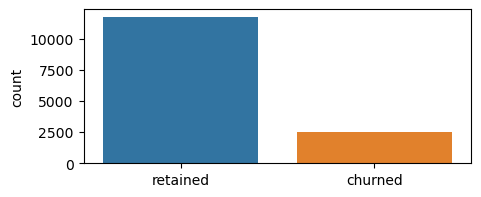

In [108]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [109]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [110]:
#The above cells show that the data is unbalanced. 
#Successful modelling may necessitate resampling to balance classes. 

<h3> Split data into testing and training datasets and standardize

In [111]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

<h1> Logistic Regression

In [112]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state = 45)

In [113]:
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=45, solver='liblinear')

In [114]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.8237762237762237
train accuracy: 0.8260337442084098


While checking for accuracy is only the first step, the well matched train/test accuracy (low variance, with only slightly higher accuracy for training set) is a good start with no obvious over/underfitting. I tried a confusion matrix and got array([[  34,  463],
       [  39, 2324]]), then different results, so went back and set a random state of 45 for consistent results

In [115]:
cm = confusion_matrix(y_test, y_predict, labels = clf_lr.classes_)
cm

array([[  47,  476],
       [  28, 2309]])

In [116]:
# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value is: {best_C}")

The best C value is: 0.08858667904100823


In [117]:
# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value is: {best_C}")


/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 2098, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/anooshmoutafian/anaconda3/

The best C value is: 0.0001


/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 2098, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/anooshmoutafian/anaconda3/

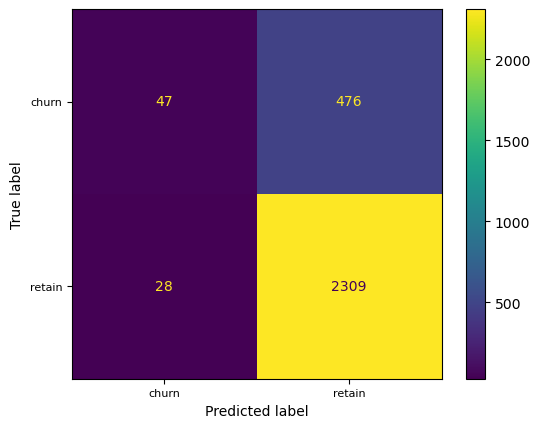

In [118]:
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm 
                                    , display_labels = ['churn', 'retain'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xticklabels(labels = ['churn', 'retain'], fontsize = 8)
ax.set_yticklabels(labels = ['churn', 'retain'], fontsize = 8)
display_cm.plot(ax = ax);

In [119]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

     churned       0.63      0.09      0.16       523
    retained       0.83      0.99      0.90      2337

    accuracy                           0.82      2860
   macro avg       0.73      0.54      0.53      2860
weighted avg       0.79      0.82      0.77      2860



<h1> K Nearest Neighbors 

In [120]:
Ks = range(1,10)

table = pd.DataFrame(columns = ['K','Accuracy'])
table['K'] = Ks

j = 0
for K in Ks:
    
    # Apply Knn model to training data
    clf_knn = KNeighborsClassifier(n_neighbors = K)
    clf_knn.fit(X_train_scaled,y_train)
    
    # Predict using model
    y_pred_knn = clf_knn.predict(X_test_scaled)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_knn)
    j += 1
    
table  

,K,Accuracy
0,1,0.753497
1,2,0.674825
2,3,0.796503
3,4,0.768881
4,5,0.804196
5,6,0.783566
6,7,0.808042
7,8,0.798252
8,9,0.810839


In [121]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [122]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.8108391608391609
train accuracy: 0.8391467785645599


In [123]:
#Use GridSearchCV to confirm best K value. Try a wider range

# Define the parameter grid: values of K to test
param_grid = {'n_neighbors': range(1, 20)}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Find the best parameters and use them to calculate accuracy on the test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

# Output the best K value and corresponding accuracy
best_k = grid_search.best_params_['n_neighbors']
print('Best K value:', best_k) 
print('Best Accuracy:', best_accuracy)

Best K value: 19
Best Accuracy: 0.8167832167832167


In [124]:
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [125]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

test accuracy: 0.8167832167832167
train accuracy: 0.8304921758895009


In [126]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

     churned       0.49      0.09      0.15       523
    retained       0.83      0.98      0.90      2337

    accuracy                           0.82      2860
   macro avg       0.66      0.53      0.52      2860
weighted avg       0.77      0.82      0.76      2860



<h2> Random Forest

In [127]:
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
model_res = clf_rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest Accuracy = ', ac)
print('Random Forest f1-score =' , f1)

Random Forest Accuracy =  0.8132867132867133
Random Forest f1-score = 0.7674442686475628


In [128]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[  67,  456],
       [  78, 2259]])

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     churned       0.46      0.13      0.20       523
    retained       0.83      0.97      0.89      2337

    accuracy                           0.81      2860
   macro avg       0.65      0.55      0.55      2860
weighted avg       0.76      0.81      0.77      2860



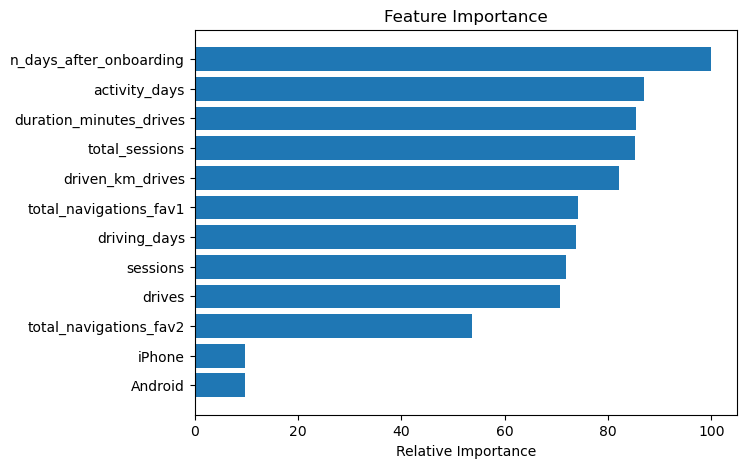

In [130]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show();